In [1]:
%load_ext autoreload

In [142]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import compute_EDMD, compute_VAR_p, construct_dictionary, perform_stability_analysis, get_stability_results, predict_EDMD, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [157]:
session = 'Mary-Anesthesia-20160912-02'

In [158]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [159]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [160]:
spike_times = spike_times[0]

# Systems

In [5]:
def vdp(x, t, mu, dynamic_noise_sd=0):
    dx = np.zeros(2)
    dx[0] = x[1] + np.random.randn()*dynamic_noise_sd
    dx[1] = mu*(1 - x[0]**2)*x[1] - x[0] + np.random.randn()*dynamic_noise_sd
    return dx

def L96(x, t, N, dt=0.01):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

# VDP Signal

In [9]:
signals = {}
signal_analysis = {}

total_time = 1000 # s
dt = 0.05 # s
subsample_step = 1
T = int(total_time/dt)
# mu_vals = [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
mu_vals = [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5]
# mu_vals = [5]
for mu in tqdm(mu_vals):
    x0 = np.random.randn()*2
    y0 = np.random.randn()*2
    
    # ------------
    # SCIPY
    # -----------
    dynamic_noise_sd = 0
    
    t = np.arange(0.0, total_time, dt)
    data = odeint(lambda x, t: vdp(x, t, mu=mu, dynamic_noise_sd=dynamic_noise_sd), [x0, y0], t)
    
    signals[f"mu = {mu}"] = data[np.arange(0, data.shape[0], subsample_step)]
        
signal_analysis = {}

  0%|          | 0/12 [00:00<?, ?it/s]

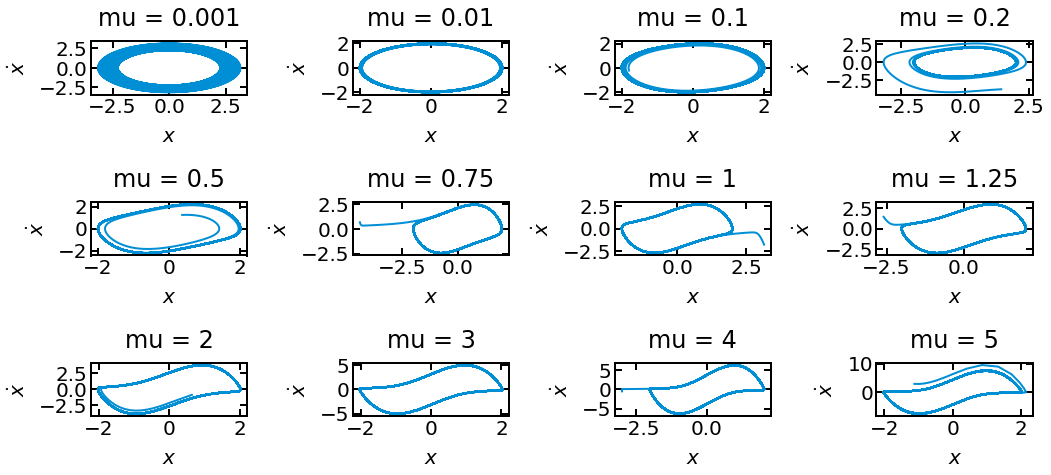

In [22]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(15, 7))

for i, (key, signal) in enumerate(signals.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    ax.plot(signal[:, 0], signal[:, 1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    ax.set_title(f"{key}")
plt.tight_layout()
plt.show()

In [163]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [446]:
sig = signals['mu = 5'][:5000]
# sig = lfp[600*1000:600*1000 + 5000]

pred_sig = signals['mu = 5'][5000:7500]
# pred_sig = lfp[600*1000 + 5000:600*1000 + 5100]

In [449]:
p = 50
max_order = 4
include_signal = False
PCA_dim = -1
grouped_by = 2
# grouped_by = PCA_dim
normalize = True
lamb_vals = [0, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10, 25, 50, 100]
# lamb_vals = [25, 50, 100, 150, 200, 250, 500, 1000]
rets = {}
for lamb in tqdm(lamb_vals):
    rets[lamb] = compute_EDMD(sig, p=p, lamb=lamb, trim_CIs=True, PCA_dim=PCA_dim, max_order=max_order, grouped_by=grouped_by, include_signal=include_signal, normalize=normalize)
#     rets[lamb] = compute_VAR_p(sig, p=p, lamb=lamb, trim_CIs=True, normalize=normalize)

  0%|          | 0/15 [00:00<?, ?it/s]

(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)
(4951, 1201)


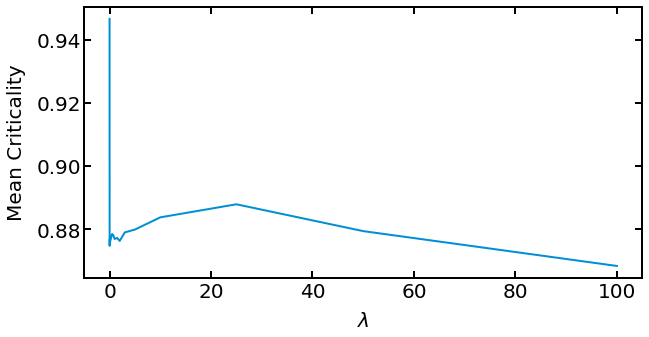

In [450]:
plt.plot(lamb_vals[0:15], [rets[lamb]['criticality_inds'].mean() for lamb in lamb_vals][0:15])
plt.xlabel(r"$\lambda$")
plt.ylabel("Mean Criticality")
plt.show()

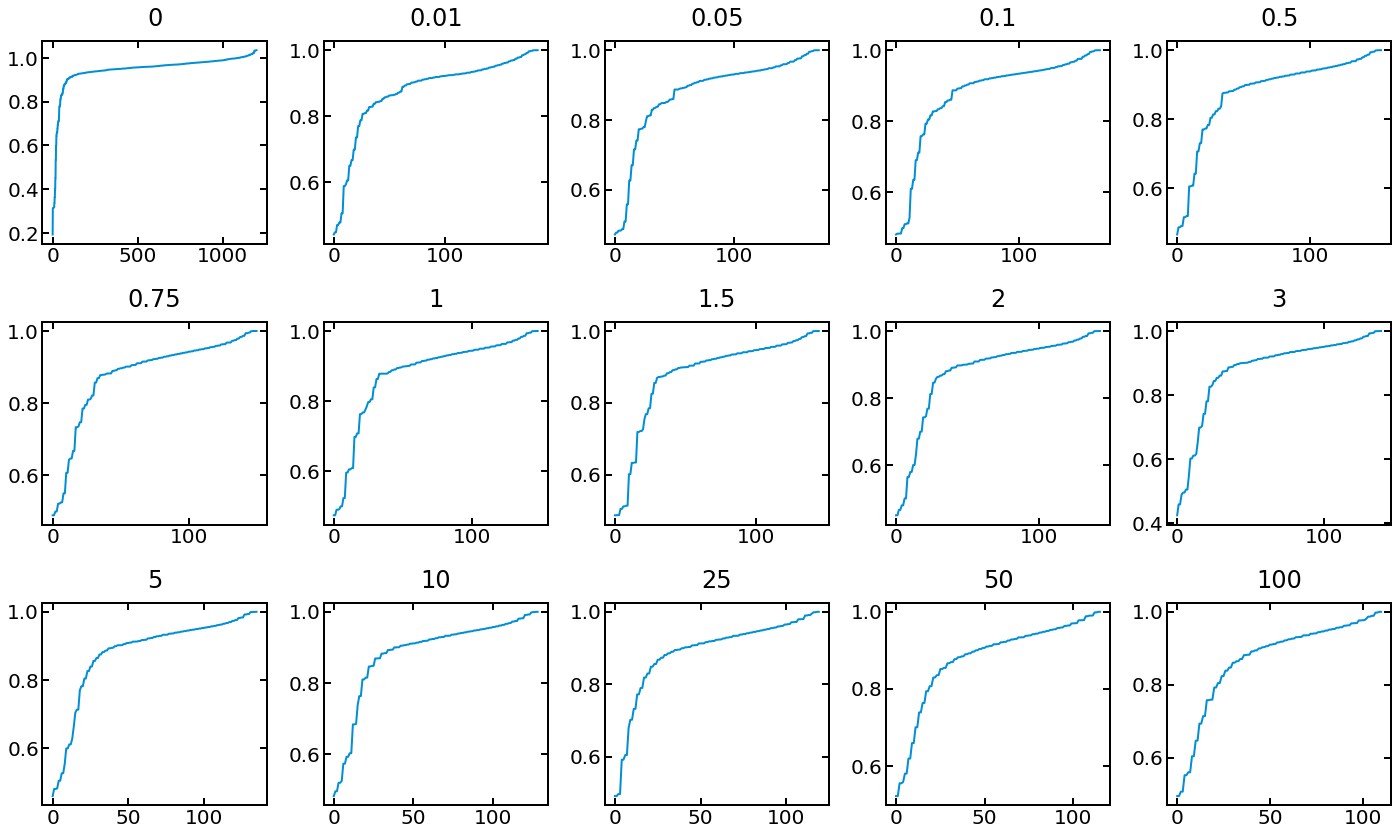

In [451]:
rows = 3
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))
for i in range(len(lamb_vals)):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
        
    ax.set_title(lamb_vals[i])
    
    ax.plot(rets[lamb_vals[i]]['criticality_inds'])
plt.tight_layout()
plt.show()

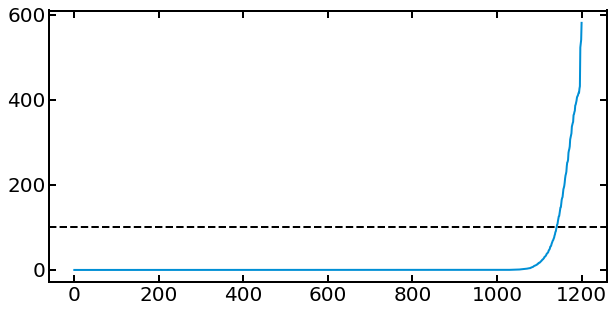

In [452]:
plt.plot(np.sort(rets[100]['S']))
plt.axhline(lamb, linestyle='--', c='k')

In [490]:
predict_type = 'all'
predictions = {}
true_vals = {}
pb_mses = {}
pbs = {}
for lamb in tqdm(lamb_vals):
    predictions[lamb], true_vals[lamb], pb_mses[lamb], pbs[lamb] = predict_EDMD(pred_sig[:100], rets[lamb]['coefs'], p=p, PCA_dim=PCA_dim, max_order=max_order, grouped_by=grouped_by, include_signal=include_signal, normalize=normalize, predict_type=predict_type, persistence_baseline=True)
#     predictions[lamb], true_vals[lamb], pb_mses[lamb], pbs[lamb] = predict_VAR_p(pred_sig, rets[lamb]['coefs'], rets[lamb]['intercept'], persistence_baseline=True, normalize=normalize)

  0%|          | 0/15 [00:00<?, ?it/s]

In [491]:
mses = [((predictions[lamb] - true_vals[lamb])**2).mean() for lamb in lamb_vals]

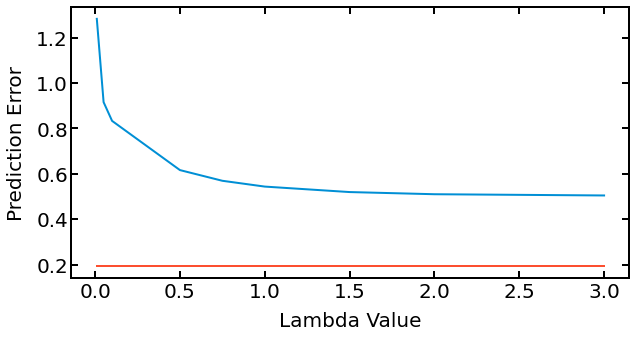

In [492]:
start = 1
end = 10
plt.plot(lamb_vals[start:end], mses[start:end])
plt.plot(lamb_vals[start:end], [pb_mses[lamb] for lamb in lamb_vals][start:end], label='persistence_baseline')
# plt.legend()
plt.xlabel('Lambda Value')
plt.ylabel('Prediction Error')
plt.show()

0.3218979135406307
0.006581827356332718


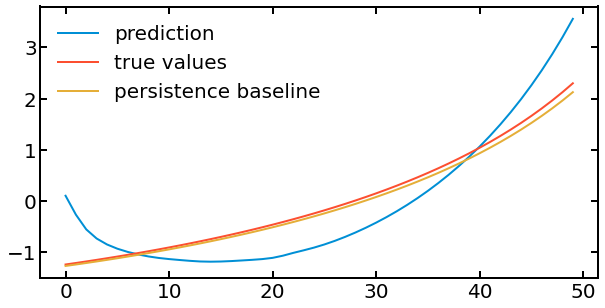

In [493]:
lamb_val = 3
ind = 21
plt.plot(predictions[lamb_val][:, ind], label='prediction')
print(((predictions[lamb_val][:, ind] - true_vals[lamb_val][:, ind])**2).mean())
plt.plot(true_vals[lamb_val][:, ind], label='true values')
plt.plot(pbs[lamb_val][:, ind], label='persistence baseline')
print(((pbs[lamb_val][:, ind] - true_vals[lamb_val][:, ind])**2).mean())
plt.legend()
plt.show()

In [478]:
((pbs[lamb_val] - true_vals[lamb_val])**2).mean()

0.3034973874586366

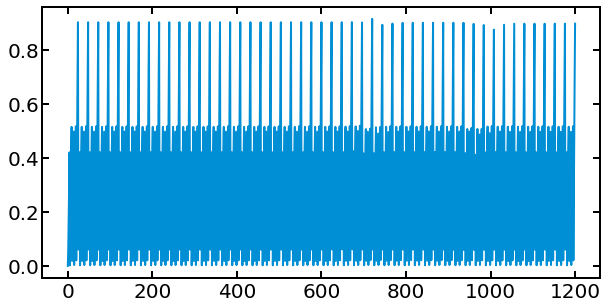

In [479]:
plt.plot(((pbs[lamb_val] - true_vals[lamb_val])**2).mean(axis=0))

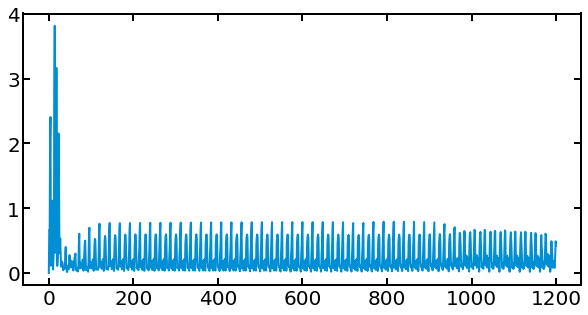

In [480]:
plt.plot(((predictions[lamb_val] - true_vals[lamb_val])**2).mean(axis=0))

In [484]:
np.where(((predictions[lamb_val] - true_vals[lamb_val])**2).mean(axis = 0) < ((pbs[lamb_val] - true_vals[lamb_val])**2).mean(axis = 0))[0]

array([  21,   28,   31,   32,   33,   35,   36,   37,   38,   41,   42,
         43,   45,   46,   47,   48,   50,   51,   52,   54,   55,   56,
         57,   59,   60,   61,   62,   64,   65,   66,   67,   69,   70,
         71,   72,   74,   75,   76,   78,   79,   80,   81,   88,   89,
         90,   91,   93,   94,   95,   96,   98,   99,  100,  102,  103,
        104,  105,  112,  113,  114,  115,  117,  118,  119,  120,  122,
        123,  124,  126,  127,  128,  129,  136,  137,  138,  139,  141,
        142,  143,  144,  146,  147,  148,  150,  151,  152,  153,  160,
        161,  162,  163,  165,  166,  167,  168,  170,  171,  172,  174,
        175,  176,  177,  184,  185,  186,  187,  189,  190,  191,  192,
        194,  195,  196,  198,  199,  200,  201,  208,  209,  210,  211,
        213,  214,  215,  216,  218,  219,  220,  222,  223,  224,  225,
        232,  233,  234,  235,  237,  238,  239,  240,  242,  243,  244,
        246,  247,  248,  249,  256,  257,  258,  2

In [496]:
sig.shape

(5000, 2)